In [1]:
%run ./2020-02-13_utils.ipynb
import copy
import re
import copy
import sys
sys.path.append('/ahg/regevdata/users/oursu/code/MIMOSCA')

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000
pref=SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.1000cells.analysis.regressed_out_vbc'

FIGS=DATA+'/Figures_regressed_out_vbc/'
print(FIGS)


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/Figures_regressed_out_vbc/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.analysis.regress_out_vbc.h5ad',cache=False)
adata

Only considering the two last: ['.regress_out_vbc', '.h5ad'].
Only considering the two last: ['.regress_out_vbc', '.h5ad'].


AnnData object with n_obs × n_vars = 150044 × 1145 
    obs: 'KRAS_A146P', 'KRAS_A146T', 'KRAS_A146V', 'KRAS_A59E', 'KRAS_A59G', 'KRAS_A59T', 'KRAS_AG11TD', 'KRAS_AG59GV', 'KRAS_C118S', 'KRAS_D119G', 'KRAS_D33E', 'KRAS_D57N', 'KRAS_E31K', 'KRAS_E63K-', 'KRAS_G12A', 'KRAS_G12C', 'KRAS_G12D', 'KRAS_G12F', 'KRAS_G12I', 'KRAS_G12R', 'KRAS_G12S', 'KRAS_G12V', 'KRAS_G12Y', 'KRAS_G13C', 'KRAS_G13E', 'KRAS_G13R', 'KRAS_G13V', 'KRAS_G60D', 'KRAS_G60S', 'KRAS_G60V', 'KRAS_H166Y', 'KRAS_I163S', 'KRAS_I36M', 'KRAS_K117N', 'KRAS_K117R', 'KRAS_K147N', 'KRAS_K147T', 'KRAS_K176Q', 'KRAS_K5E', 'KRAS_L159S', 'KRAS_L19F', 'KRAS_L52F', 'KRAS_L79I', 'KRAS_M111L', 'KRAS_N26Y', 'KRAS_P110S', 'KRAS_P34L', 'KRAS_P34R', 'KRAS_Q22H', 'KRAS_Q22K', 'KRAS_Q25H', 'KRAS_Q61A', 'KRAS_Q61H', 'KRAS_Q61K', 'KRAS_Q61L', 'KRAS_Q61P', 'KRAS_Q61R', 'KRAS_Q99E', 'KRAS_R135T', 'KRAS_R149K', 'KRAS_R164Q', 'KRAS_R41K', 'KRAS_R68S', 'KRAS_T144P', 'KRAS_T158A', 'KRAS_T20M', 'KRAS_T20R', 'KRAS_T50I', 'KRAS_T50P', 'KRAS_T58I', 'KRAS

In [6]:
del adata.obsp['connectivities']
del adata.obsp['distances']

In [7]:
import perturbseq as perturb
adata=perturb.pp.subsample_cells(adata,1000,'mut.std')

In [9]:
#score cell cycle while we are at it
data_dir = '/ahg/regevdata/projects/Cell2CellCommunication/code/sc_eVIP/analysis/2020-02-14/'
cc_phases = np.loadtxt(os.path.join(data_dir,'cell_cycle_genes.csv'),delimiter=',',dtype=str)
### table S2 from Macosko 2015, https://www.cell.com/fulltext/S0092-8674(15)00549-8

'''
"Gene sets reflecting five phases of the HeLa cell cycle (G1/S, S, G2/M, M and M/G1) were taken from
Whitfield et al. (Whitfield et al., 2002) (Table S2), and refined by examining the correlation between
the expression pattern of each gene and the average expression pattern of all genes in the respective
gene-set, and excluding genes with a low correlation (R<0.3). This step removed genes that were
identified as phase-specific in HeLa cells but did not correlate with that phase in our single-cell data.
The remaining genes in each refined gene-set were highly correlated (not shown). We then averaged the
normalized expression levels (log2(TPM+1)) of the genes in each gene-set to define the phase-specific
scores of each cell. These scores were then subjected to two normalization steps. First, for each phase,
the scores were centered and divided by their standard deviation. Second, the normalized scores of each
cell were centered and normalized. 

To order cells according to their progression along the cell cycle, we first compared the pattern of
phase-specific scores of each cell to eight potential patterns along the cell cycle: only G1/S is on, both
G1/S and S, only S, only G2/M, G2/M and M, only M, only M/G1, M/G1 and G1. We also added a
ninth pattern for equal scores of all phases (either all active or all inactive). Each pattern was defined
simply as a vector of ones for active programs and zeros for inactive programs. We then classified the
cells by the defined patterns based on the maximal correlation of the phase-specific scores with these
potential patterns. Importantly, none of the cells were classified to the ninth pattern of equal activity,
while multiple cells were assigned to each of the other patterns. To further order the cells within each
class, we sorted the cells based on their relative correlation with the preceding and succeeding patterns,
thereby smoothing the transitions between classes (Figure 4A)
'''

cc_phases_dict = {}
for i in range(cc_phases.shape[1]):
    phase = cc_phases[0,i].strip()
    if '\ufeff' in phase:
        phase = phase.split('\ufeff')[1]
    cc_phases_dict[phase] = [val.strip() for val in cc_phases[1:,i] if len(val) > 1]

In [10]:
from scipy.stats import spearmanr

genes=adata.var_names
filtered_X=adata.X
genes2keep_dict = {phase: [] for phase in cc_phases_dict.keys()}
for phase in cc_phases_dict.keys():
    phase_gene_inds = [list(genes).index(gene) for gene in cc_phases_dict[phase] if gene in genes]
    print(phase,len(phase_gene_inds),'/',len(cc_phases_dict[phase]))
    phase_gene_means = filtered_X[:,phase_gene_inds].mean(1)
    for ind in phase_gene_inds:
#         cells2keep = np.where(filtered_X[:,ind] != 0)[0]
        rho,p = spearmanr(filtered_X[:,ind],phase_gene_means)
        if rho > 0.3:
            genes2keep_dict[phase].append(genes[ind])
    print(phase,len(genes2keep_dict[phase]),'/',len(cc_phases_dict[phase]))
    print('-----')

G1/S 12 / 100
G1/S 6 / 100
-----
S 15 / 113
S 5 / 113
-----
G2/M 40 / 133
G2/M 24 / 133
-----
M 47 / 151
M 39 / 151
-----
M/G1 21 / 106
M/G1 12 / 106
-----


In [11]:
# NORMALIZE ACROSS PHASES (S.T. NO SINGULAR CELL CYCLE PHASE SCORE/EXPRESSION PROFILES DOMINATES!)
phases = sorted(list(genes2keep_dict.keys()))
cc_scores = np.zeros((filtered_X.shape[0],len(phases)))

for i,phase in enumerate(phases):
    phase_gene_inds = [list(genes).index(gene) for gene in genes2keep_dict[phase]] 
    cc_scores[:,i] = filtered_X[:,phase_gene_inds].mean(1)

# normalize scores (across phases)
cc_scores = (cc_scores - cc_scores.mean(0))/cc_scores.std(0)

# # normalize scores (across cells) - DO NOT INCLUDE
# cc_scores = ((cc_scores.T - cc_scores.mean(1))/cc_scores.std(1)).T

In [12]:
import re
for i,phase in enumerate(phases):
    adata.obs[re.sub('/','.',phase)]=cc_scores[:,i]

Trying to set attribute `.obs` of view, copying.


In [13]:
for phase in cc_phases_dict:
    sc.pl.umap(adata,color=[re.sub('/','.',phase)],cmap='bwr',vmin=-1,vmax=1)

In [14]:
cycling_labels = ((cc_scores < 0).sum(1) != len(phases))

In [15]:
cc_stages = np.array([phases[i] for i in np.argmax(cc_scores,axis=1)])

In [16]:
import re
phase_assignments = []
for i,label in enumerate(cycling_labels):
    if label == 0:
        phase_assignments.append('G0')
    else:
        phase_assignments.append(re.sub('/','.',cc_stages[i]))

In [17]:
adata.obs['phase.multi']=phase_assignments
sc.pl.umap(adata,color=['phase.multi'])

... storing 'phase.multi' as categorical


In [18]:
adata.obs['phase.multi'].cat.categories=['G0','G1.S','S','G2.M','M','M.G1']
adata.uns['phase.multi_colors']=['black','purple','red','orange','yellow','cyan']
sc.pl.umap(adata,color=['phase.multi'])

adata.obs['phase.multi'].cat.categories=['G0','G1.S','S','G2.M','M','M.G1']
adata.uns['phase.multi_colors']=['gray','purple','red','orange','yellow','lightblue']
sc.pl.umap(adata,color=['phase.multi'])

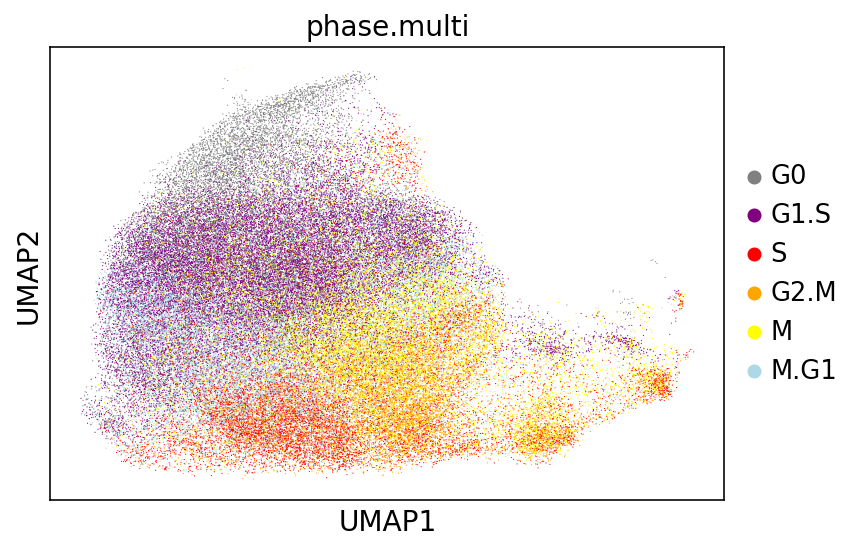

In [19]:
%matplotlib inline
sc.pl.umap(adata,color=['phase.multi'])

In [20]:
adata.write(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.h5ad')